After creating two preliminary models for Logistic Regression and Decision Trees, its time to fine tune them and make sure they are running how they should. Just like before I am importing the dataframe used for those models, setting my target and predictor, one-hot-encoding, and making my train-test-split.

In [219]:
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [3]:
df1 = pd.read_csv('EDA_df.csv')
df1.head()

,Unnamed: 0,Subject Age Group,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Arrest Flag,Frisk Flag
0,0,Unknown,Arrest,None,7500,1980s,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,N,N
1,1,Unknown,Field Contact,None,5670,1960s,M,White,Unknown,Unknown,2015-03-19T00:00:00,07:59:00,N,N
2,3,Unknown,Field Contact,None,7539,1960s,M,White,Unknown,Unknown,2015-04-01T00:00:00,04:55:00,N,N
3,4,Unknown,Field Contact,None,6973,1970s,M,White,Black or African American,Male,2015-04-03T00:00:00,00:41:00,N,N
4,5,Unknown,Field Contact,None,7402,1970s,M,White,Black or African American,Male,2015-04-05T00:00:00,23:46:00,N,N


In [4]:
target = df1['Arrest Flag']
predictors = df1.drop(columns = ['Arrest Flag'], axis = 1)

In [5]:
dummy_predictors = pd.get_dummies(predictors, drop_first=False)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dummy_predictors, target, random_state=11)

With the same Decision Tree Classifier, the feature importance are being calculated.

In [7]:
TreeClassifier = DecisionTreeClassifier(random_state=11)  
TreeClassifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=11)

In [103]:
TreeClassifier.feature_importances_

array([0.00395128, 0.00304149, 0.        , ..., 0.        , 0.        ,
       0.        ])

Using a function to make calculations and plot the top important features.

This function takes in the model/classifier as well as the dataframe for the predictors/x/x_train. 
Next it creates a list (of tuples) and assigns it to the Top10 variable. This is done by calculating the feature importances of the model that was imput and zip those values with the corresponding column names for the dataframe used. 
This creates the tuples and next these are turned into a list of tuples. 
Finally these are sorted in reverse order since the default is to go in ascending order, since values with the highest score is what we are interested in. 
Finally this is indexed to the top 10 values, mostly for computer performance issues.

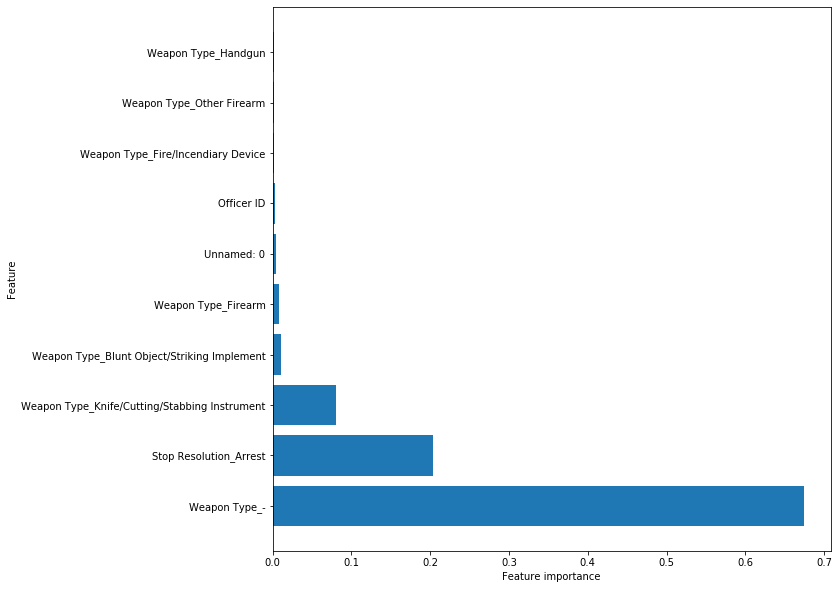

In [165]:
def plot_feature_importances(model, X_DF):
    Top10 = sorted(list(zip(model.feature_importances_, X_DF.columns.values)), reverse = True)[:10]
    importance = [i[0] for i in Top10]
    column = [i[1] for i in Top10]
    
    n_features = len(Top10)
    plt.figure(figsize=(10,10))
    plt.barh(range(n_features), importance, align='center') 
    plt.yticks(np.arange(n_features), column) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(TreeClassifier, X_train)

After running this visualization to see what affects the model the most, I realize that I did not do a good enough job during EDA and data cleaning. The column 'Stop Resolution_Arrest' will obviously be highly correlated with the target column since the target is whether or not someone was arrested. It will be important to drop this column to evaluate the models performance without it. 'Unnamed:' 0 was also from an index and should be removed as well since the values in that coulmn have no significance since they are just the line number from the original csv. Also while expanding the sample size to 20, some time slots appeared to have more significance. Since these have not been binned into time groups, it seems suspicious that a certain time within the day would be so important that the only thing that I could think of was that possibly a group of suspects were all arrested at that time. For now, all time columns will be deleted as well and will possibly be added back in for evaluation after splitting them to groupings similar to the officer age (sometime in the future).

In [163]:
df2 = df1.drop(columns = ['Unnamed: 0', 'Stop Resolution', 'Reported Time' ], axis = 1)
df2

,Subject Age Group,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Arrest Flag,Frisk Flag
0,Unknown,None,7500,1980s,M,Black or African American,Asian,Male,2015-10-16T00:00:00,N,N
1,Unknown,None,5670,1960s,M,White,Unknown,Unknown,2015-03-19T00:00:00,N,N
2,Unknown,None,7539,1960s,M,White,Unknown,Unknown,2015-04-01T00:00:00,N,N
3,Unknown,None,6973,1970s,M,White,Black or African American,Male,2015-04-03T00:00:00,N,N
4,Unknown,None,7402,1970s,M,White,Black or African American,Male,2015-04-05T00:00:00,N,N
...,...,...,...,...,...,...,...,...,...,...,...
44844,56 and Above,-,8668,1990s,F,White,White,Male,2020-11-24T00:00:00,N,N
44845,56 and Above,-,8747,1990s,M,White,Unknown,Male,2020-11-25T00:00:00,N,N
44846,56 and Above,-,7456,1970s,M,White,White,Male,2020-12-03T00:00:00,N,N
44847,56 and Above,Knife/Cutting/Stabbing Instrument,8646,1990s,M,White,Black or African American,Male,2020-12-15T00:00:00,N,Y


In [171]:
df2.to_csv(r'C:\Users\melfr\Documents\Flatiron\p3\phase_project\terry_analysis\FriskAnalysis\final_df.csv')

With the new dataframe, I am now creating new target and predictor value and following the same initial steps prior to fitting a model. The Decision Tree Classifier will be used again to calculate and plot the top 10 important features.

In [164]:
target_NEW = df2['Arrest Flag']
predictors_NEW = df2.drop(columns = ['Arrest Flag'], axis = 1)

In [179]:
target_NEW.replace({"N": 0, "Y": 1}, inplace=True)
predictors_NEW['Frisk Flag'].replace({"N": 0, "Y": 1}, inplace=True)

In [180]:
dummy_predictors_NEW = pd.get_dummies(predictors_NEW, drop_first=False)

In [181]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(dummy_predictors_NEW, target_NEW, random_state=11)

In [182]:
TreeClassifier2 = DecisionTreeClassifier(random_state=11)  
TreeClassifier2.fit(X_train2, y_train2)

DecisionTreeClassifier(random_state=11)

In [194]:
TreeClassifier2.feature_importances_

array([0.10487198, 0.00759592, 0.00160812, ..., 0.        , 0.00059423,
       0.        ])

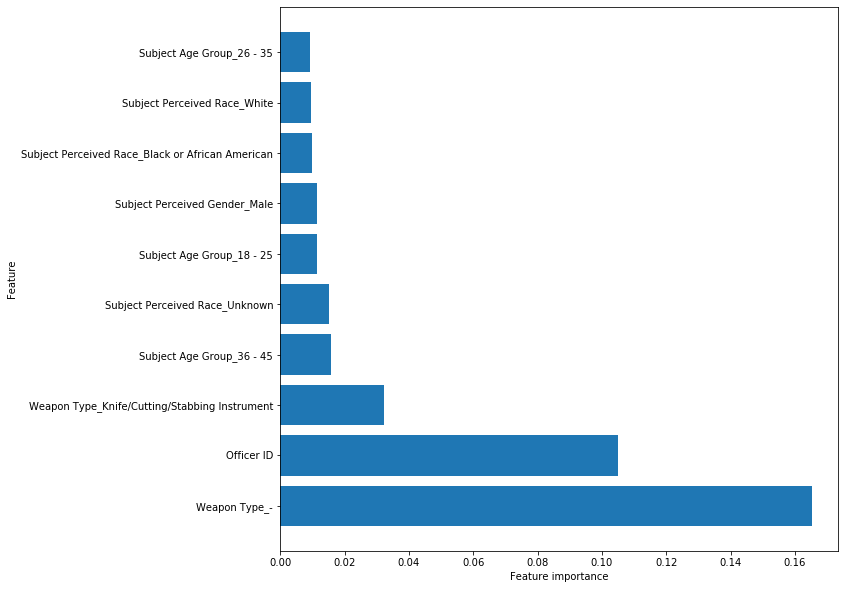

In [184]:
plot_feature_importances(TreeClassifier2, X_train2)

This seems to be a lot more reasonable and to be expected, while there are some predictors that weigh more heavily than others, it still doesn't pass a 0.20 threshold so it's not overwelming. Before implementing Bagged Trees, I want to also go back and reevaluate the logistic regression and decision tree models with this new dataset.

Rebuilding the logistic regression model from the previous notebook:

In [185]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs')
model_log = logreg.fit(X_train2, y_train2)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False)

In [186]:
yhat_trainLOG = logreg.predict(X_train2)
yhat_testLOG = logreg.predict(X_test2)

In [188]:
yhat_trainLOG.astype('float64')
yhat_testLOG.astype('float64')

residuals = np.abs(y_train2 - yhat_trainLOG)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    31459
1     2177
Name: Arrest Flag, dtype: int64
0    0.935278
1    0.064722
Name: Arrest Flag, dtype: float64


In [189]:
def model_eval(YTrain, YTest, YHat_Train, YHat_Test):
    PrecisionTrain = precision_score(YTrain, YHat_Train)
    PrecisionTest = precision_score(YTest, YHat_Test)
    RecallTrain = recall_score(YTrain, YHat_Train)
    RecallTest = recall_score(YTest, YHat_Test)
    AccuracyTrain = accuracy_score(YTrain, YHat_Train)
    AccuracyTest = accuracy_score(YTest, YHat_Test)
    F1Train = f1_score(YTrain, YHat_Train)
    F1Test = f1_score(YTest, YHat_Test)
    print('Precision Score:\nTrain: {}  Test: {}\nRecall Score:\nTrain: {}  Test {}\nAccuracy Score:\nTrain: {}  Test: {}\nF1 Score:\nTrain: {}  Test: {}'.format(
                                                    PrecisionTrain, PrecisionTest, RecallTrain, RecallTest, 
                                                    AccuracyTrain, AccuracyTest, F1Train, F1Test))

In [191]:
cnf_matrixLOG = confusion_matrix(y_test2, yhat_testLOG)
cnf_matrixLOG

array([[10487,    72],
       [  610,    44]], dtype=int64)

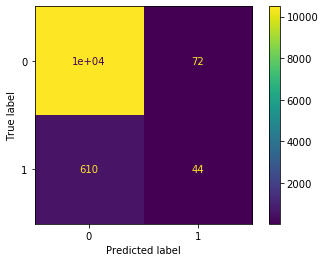

In [192]:
plot_confusion_matrix(logreg, X_test2, y_test2)
plt.show()

In [190]:
model_eval(y_train2, y_test2, yhat_trainLOG, yhat_testLOG)

Precision Score:
Train: 0.36363636363636365  Test: 0.3793103448275862
Recall Score:
Train: 0.061508889956751564  Test 0.0672782874617737
Accuracy Score:
Train: 0.9352776786776074  Test: 0.9391777401230714
F1 Score:
Train: 0.10521989313604604  Test: 0.11428571428571428


In [229]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, yhat_testLOG)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUC is :{0}'.format(round(roc_auc, 2)))

AUC is :0.53


It's pretty interesting to see how much the model changed by deleting those three columns. The accuracy went up a little but nearly all the other scores went down. This confirms that logistic regression is not the best model approach for this data.

Next to rebuild the decision tree model from the previous notebook:

In [195]:
#because a decision tree model was used to make the second plot for feature importance, we can just build off that model.
ypred_testTREE = TreeClassifier2.predict(X_test2)
ypred_trainTREE = TreeClassifier2.predict(X_train2)

In [199]:
cnf_matrix = confusion_matrix(y_test2, ypred_testTREE)
cnf_matrix

array([[10266,   293],
       [  498,   156]], dtype=int64)

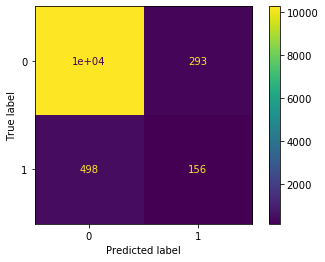

In [200]:
plot_confusion_matrix(TreeClassifier2, X_test2, y_test2)
plt.show()

In [196]:
model_eval(y_train2, y_test2, ypred_trainTREE, ypred_testTREE)

Precision Score:
Train: 0.9995159728944821  Test: 0.34743875278396436
Recall Score:
Train: 0.992311388755406  Test 0.23853211009174313
Accuracy Score:
Train: 0.9994945891306933  Test: 0.9294568804066708
F1 Score:
Train: 0.9959006510730649  Test: 0.2828649138712602


In [198]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, ypred_testTREE)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUC is :{0}'.format(round(roc_auc, 2)))

AUC is :0.61


This confirms some of my suspicion that the model was performing better than it should and that the previous data was causing it to overfit. While the AUC of 0.61 is still ok, I believe it will be important to implemente tree ensemble methods to see if can make the results even better.

In [206]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=100)
bagged_tree.fit(X_train2, y_train2)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=100)

In [207]:
BaggedTree_test = bagged_tree.predict(X_test2)
BaggedTree_train = bagged_tree.predict(X_train2)

In [208]:
model_eval(y_train2, y_test2, BaggedTree_train, BaggedTree_test)

Precision Score:
Train: 1.0  Test: 1.0
Recall Score:
Train: 0.005766458433445459  Test 0.0015290519877675841
Accuracy Score:
Train: 0.9384885242002616  Test: 0.9417640239008294
F1 Score:
Train: 0.011466794075489728  Test: 0.0030534351145038168


In [209]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, BaggedTree_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUC is :{0}'.format(round(roc_auc, 2)))

AUC is :0.5


While Bagged Trees increased the Accuracy a little, Precision nearly doubled. However AUC droped down to 50%. Using the Random Forest model will be next.

In [210]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=5)

In [211]:
Forest_test = forest.predict(X_test2)
Forest_train = forest.predict(X_train2)

In [212]:
model_eval(y_train2, y_test2, Forest_train, Forest_test)

Precision Score:
Train: 0.0  Test: 0.0
Recall Score:
Train: 0.0  Test 0.0
Accuracy Score:
Train: 0.9381317635866334  Test: 0.9416748417015963
F1 Score:
Train: 0.0  Test: 0.0


In [213]:
cnf_matrix = confusion_matrix(y_test2, Forest_test)
cnf_matrix

array([[10559,     0],
       [  654,     0]], dtype=int64)

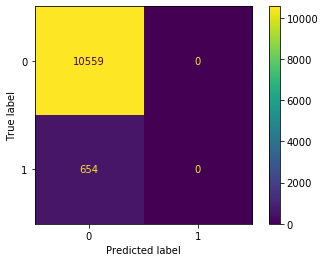

In [214]:
plot_confusion_matrix(forest, X_test2, y_test2)
plt.show()

In [215]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, Forest_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUC is :{0}'.format(round(roc_auc, 2)))

AUC is :0.5


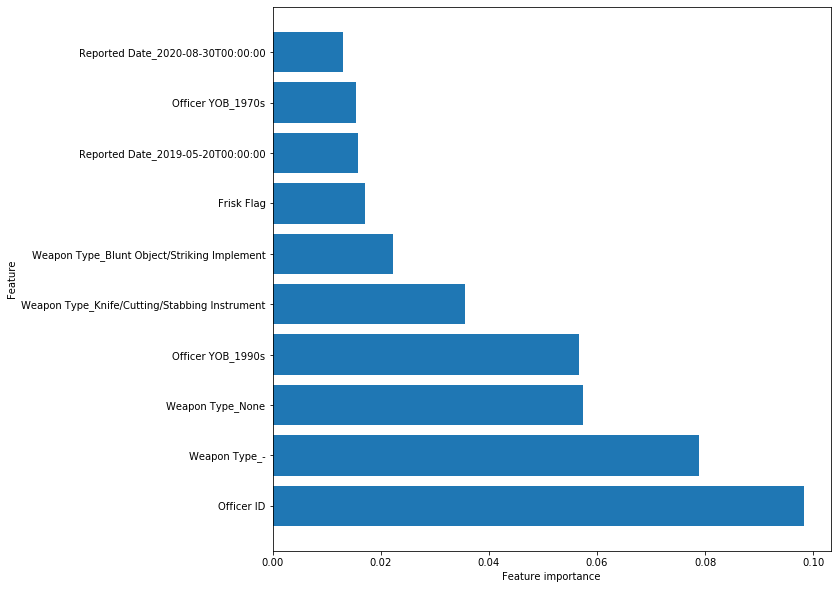

In [217]:
plot_feature_importances(forest, X_train2)

Surprisingly, the Decision Tree ensemble methods for bagging and boosting seems to not have helped the model. This could be from either user error (me) or data being overfit. Looking at the values for feature importance, it is also interesting that the third most important feature is Weapon Type - None. More evaluation of the Weapon Type column may be needed.

Finally XGBoost will be used.

In [220]:
XGB = XGBClassifier()
XGB.fit(X_train2, y_train2)

XGBClassifier()

In [221]:
training_preds = XGB.predict(X_train2)
test_preds = XGB.predict(X_test2)

In [222]:
model_eval(y_train2, y_test2, training_preds, test_preds)

Precision Score:
Train: 1.0  Test: 1.0
Recall Score:
Train: 0.0019221528111484864  Test 0.0015290519877675841
Accuracy Score:
Train: 0.9382506837911762  Test: 0.9417640239008294
F1 Score:
Train: 0.003836930455635492  Test: 0.0030534351145038168


In [223]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, test_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUC is :{0}'.format(round(roc_auc, 2)))

AUC is :0.5


In [230]:
cnf_matrix = confusion_matrix(y_test2, test_preds)
cnf_matrix

array([[10559,     0],
       [  653,     1]], dtype=int64)

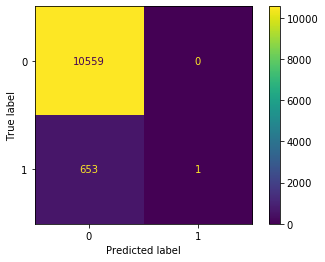

In [231]:
plot_confusion_matrix(XGB, X_test2, y_test2)
plt.show()

In [239]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [1,2,3,4,5],
    'n_estimators': [20],
}

In [240]:
grid_tune = GridSearchCV(XGB, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_tune.fit(X_train2, y_train2)

best_parameters = grid_tune.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_tune.predict(X_train2)
test_preds = grid_tune.predict(X_test2)
training_accuracy = accuracy_score(y_train2, training_preds)
test_accuracy = accuracy_score(y_test2, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.3
max_depth: 4
n_estimators: 20

Training Accuracy: 93.82%
Validation accuracy: 94.19%


In [241]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, test_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUC is :{0}'.format(round(roc_auc, 2)))

AUC is :0.5


Some parameter adjustments didn't seem to make much of a difference, however most were not able to be performed due to computer performance and time. For an initial model this one showed the most promise since Logistic Regression and the Trees seemed to have some overfitting issues. The Accuracy does seem to be quite high, however the results of the confusion tree are... confusing since there is a high amount of True Negatives, but only one True Positive, and with all the other values falling into False Negative.